Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Georgios Evangelos Margaritis"
COLLABORATORS = ""

---

# CSC_51073_EP Lab2 : Edge extraction

In this second lab, the goal is to develop linear operators on images and extract image edges.

More specifically, we will implement a Canny edge extractor.


Please read first this [tutorial on the cv2.Canny function](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html) to get an overview of the process.

In [2]:
%matplotlib inline 

import numpy as np     # grey images are stored in memory as 2D arrays, color images as 3D arrays
import cv2 as cv2      # opencv computer vision library
from skimage import io # for io.imread
from matplotlib import pyplot as plt  # ploting
from matplotlib import colors         # ploting

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

This `imshow` function is provided to display arrays of `images` with `titles`.
You can adjust the default `figsize` of (15,20) to your screen.

In [3]:
def imshow(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional

For this lab, please use a [road image](https://www.umr-lastig.fr/mathieu-bredif/data/road.jpg), typical to autonomous driving applications.

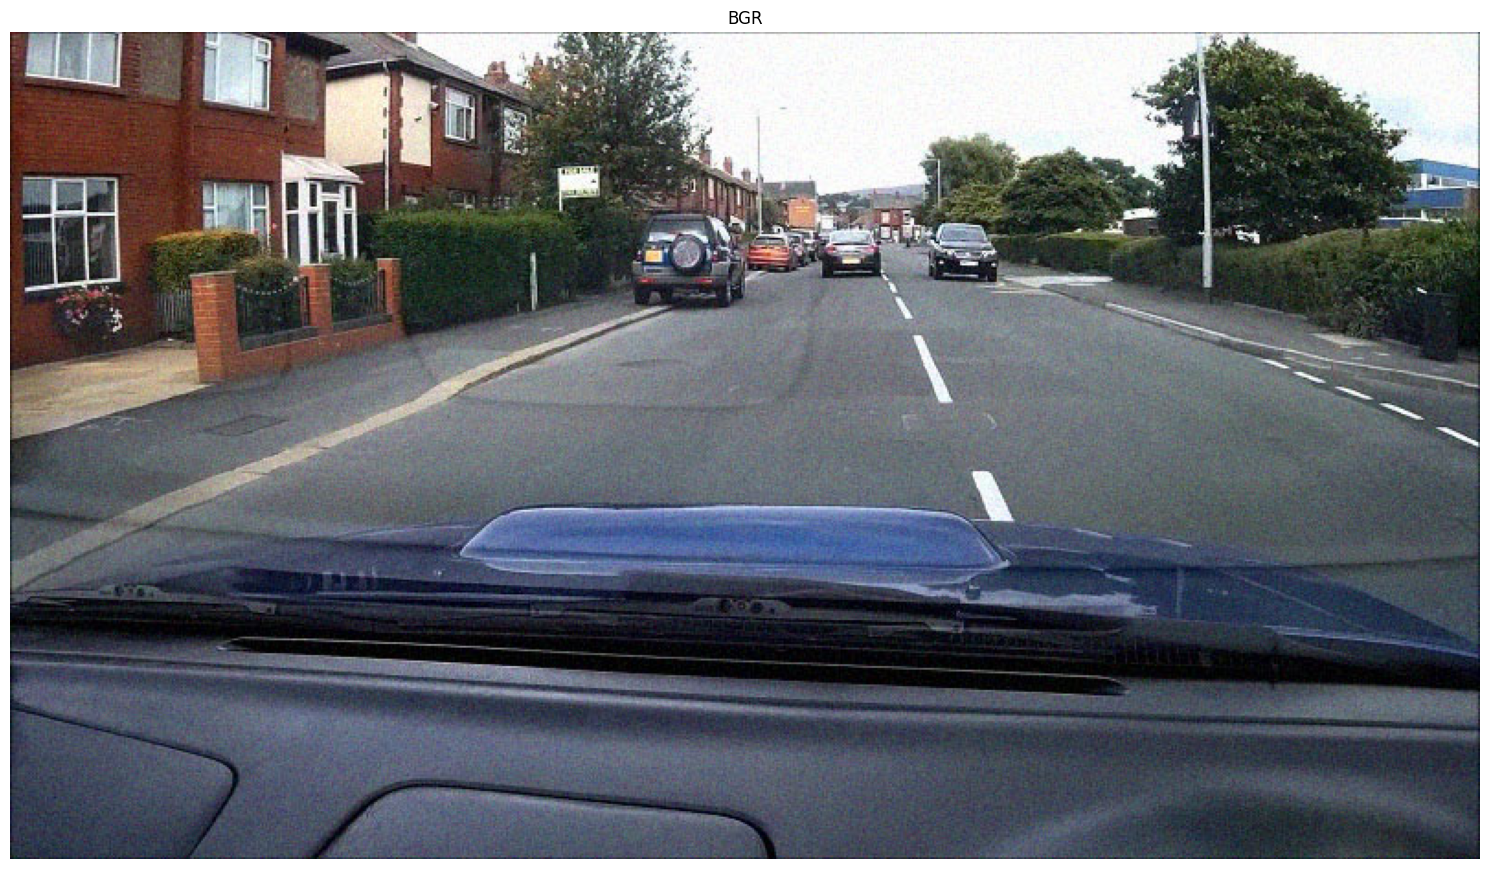

In [4]:
url = 'road_image.jpg'
imageBGR = io.imread( url ) 
imshow( [imageBGR], ['BGR']) 

# Image gradients

First, to simplify things, let's work with a gray level image.
Opencv offers many image processing functions such as the computation of image gradients. Here are the gradients computed with the 3x3 Sobel filter.

Why is there less gradient in the x direction ?

YOUR ANSWER HERE:

There's less gradient in the x-direction because the original image contains significantly more prominent horizontal lines than vertical lines with the car's dashboard being the feature in the photo that is affectig at most the differences in the two gradient images.

### The Y-Gradient ($G_y$) is Strong

The image on the right (`gy2_sobel_cv`) is very bright because it's detecting the many strong **horizontal lines** and features in the scene, including:

* The white **lane markings** on the road.
* The horizontal edges of the **curbs**.
* The car's **dashboard** which is mainly a "horizontal structure".
* Horizontal lines on the buildings, like window sills and roof lines.

Because these lines have high contrast (e.g., white paint on a dark road), they produce a very strong signal in the y-gradient.


### The X-Gradient ($G_x$) is Less

The image on the left (`gx2_sobel_cv`) is much darker because there are fewer prominent **vertical lines** in the scene for it to detect. It is picking up on features like:

* The vertical edges of the **buildings**, fences and trees.
* The vertical sides of the parked cars.

While these features are present, they are less numerous and have lower overall contrast compared to the bright, clear horizontal lines on the road.

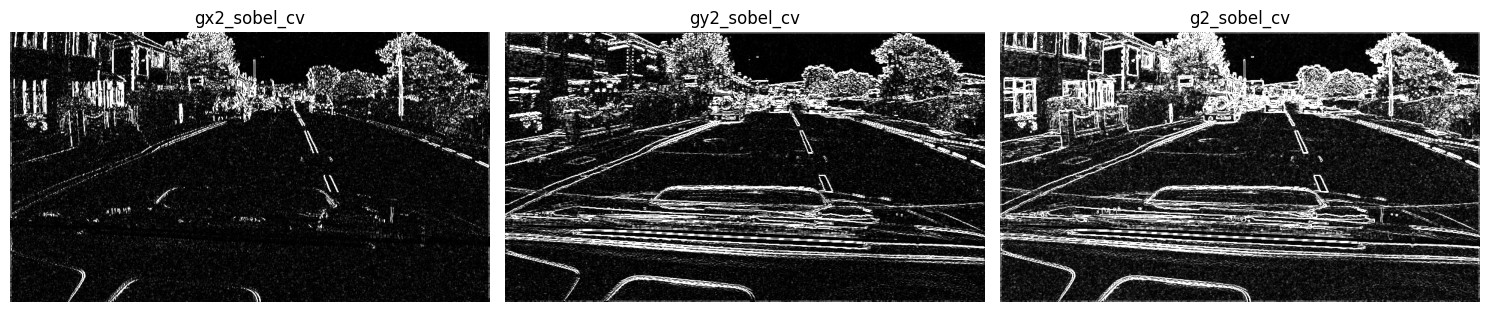

In [5]:
# Sobel operator --- cv2.Sobel(src, ddepth, dx, dy, ksize)  and /8 = normalization factor 

imageGray     = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY) # convert to grey scale the image
gx_sobel_cv   = cv2.Sobel(imageGray,cv2.CV_64F,1,0,3)/8    # compute the x-derivative using Sobel operator (kernel size 3 and normalization factor 8 )
gy_sobel_cv   = cv2.Sobel(imageGray,cv2.CV_64F,0,1,3)/8    # compute the y-derivative using Sobel operator
gx2_sobel_cv  = gx_sobel_cv ** 2                           # square of the x-derivative
gy2_sobel_cv  = gy_sobel_cv ** 2                           # square of the y-derivative
g2_sobel_cv   = gx2_sobel_cv + gy2_sobel_cv                # sum of the squares of the derivatives

imshow([gx2_sobel_cv, gy2_sobel_cv, g2_sobel_cv], ['gx2_sobel_cv', 'gy2_sobel_cv', 'g2_sobel_cv'])

Implement simple gradients using a central finite difference scheme.

A **central** finite difference scheme (f(i+1)-f(i-1)) ensures that the quantity is located at a pixel location (i), contrary to the **forward** scheme (f(i+1)-f(i)) which is located inbetween pixels at (i+0.5).

This ensures that the both gradients are defined at the pixel centers (i,j) rather than being of at (i+0.5,j) and (i,j+0.5), so that we can use them to estimate the gradient vector at (i,j)

In this question and the following, use a consistent handling of the image boundaries. What do you do when the convolution filter footprint is not entirely contained in the image ? The easiest way is to only compute and return values of pixels which convolution filter are entirely enclosed in the original images. For a 3x3 filter, that means that the output image is 2 rows and 2 columns smaller.

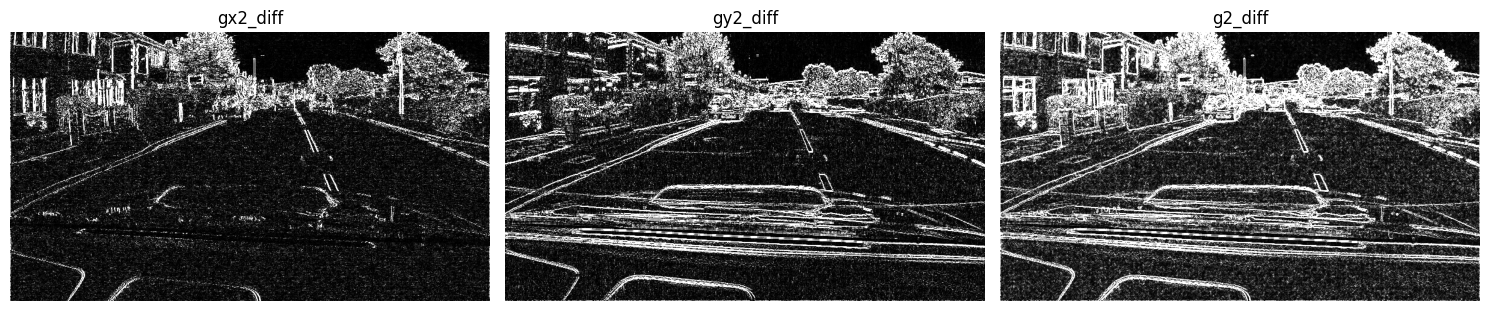

In [6]:
def gradient_y_diff(img):
  img = img.astype(float) # convert to float to avoid overflow/underflow
  # Central difference in y-direction: f(i, j+1) - f(i, j-1)
  # We return values only where filter is entirely contained -- so we remove 1 pixel from each edge
  return img[2:, 1:-1] - img[:-2, 1:-1] 

def gradient_x_diff(img):
  img = img.astype(float)
  # Central difference in x-direction: f(i+1, j) - f(i-1, j)
  # We return values only where filter is entirely contained -- so we remove 1 pixel from each edge
  return img[1:-1, 2:] - img[1:-1, :-2]

gx_diff = gradient_x_diff(imageGray)/2
gy_diff = gradient_y_diff(imageGray)/2
gx2_diff = gx_diff ** 2
gy2_diff = gy_diff ** 2
g2_diff = gx2_diff + gy2_diff
imshow([gx2_diff, gy2_diff, g2_diff], ['gx2_diff', 'gy2_diff', 'g2_diff'])

Now, try to reimplement the Sobel 3x3 filter, which coefficients are :

```
-1  0  1           1  2  1
-2  0  2   and     0  0  0
-1  0  1          -1 -2 -1
```



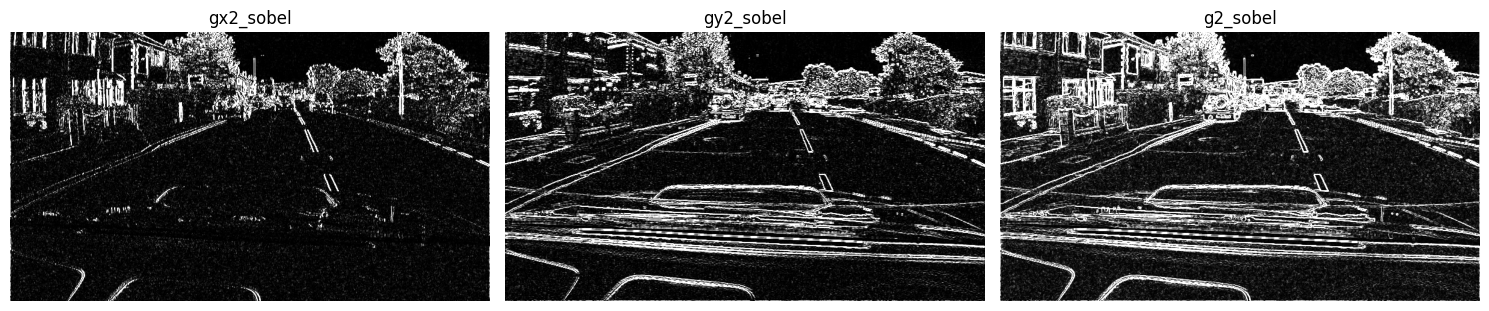

In [7]:
def gradient_y_sobel(img):
  img = img.astype(float)
  height, width = img.shape
  result = np.zeros((height - 2, width - 2))
  
  for i in range(1, height - 1):
    for j in range(1, width - 1):
      # Apply Sobel Y kernel
      result[i-1, j-1] = (1 * img[i-1, j-1]  + 2 * img[i-1, j] + 1 * img[i-1, j+1] +
                          0 * img[i, j-1]    + 0 * img[i, j]   + 0 * img[i, j+1]   +
                         -1 * img[i+1, j-1]  + -2* img[i+1, j] + -1* img[i+1, j+1])
  return result

def gradient_x_sobel(img): # Sobel X filter: [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], this detects vertical edges (changes in X direction)
  img = img.astype(float)
  height, width = img.shape
  result = np.zeros((height - 2, width - 2))
  
  for i in range(1, height - 1):
    for j in range(1, width - 1):
      result[i-1, j-1] = (-1 * img[i-1, j-1] + 0 * img[i-1, j] + 1 * img[i-1, j+1] +
                          -2 * img[i, j-1]   + 0 * img[i, j]   + 2 * img[i, j+1] +
                          -1 * img[i+1, j-1] + 0 * img[i+1, j] + 1 * img[i+1, j+1])
  return result

gx_sobel = gradient_x_sobel(imageGray)/8
gy_sobel = gradient_y_sobel(imageGray)/8
gx2_sobel = gx_sobel ** 2
gy2_sobel = gy_sobel ** 2
g2_sobel = gx2_sobel + gy2_sobel
imshow([gx2_sobel, gy2_sobel, g2_sobel], ['gx2_sobel', 'gy2_sobel', 'g2_sobel'])

Define the threshold function that takes an image and a threshold value and output an image of the same size which pixel values are 255 if the input value is above the threshold, or 0 otherwise.

In [8]:
def threshold(img, value):
  result = np.zeros_like(img) # output image of same size as input
  result[img > value] = 255   # set pixels above the threshold to 255 (white)

  return result

Try to find the best threshold, that do not select noise, but that miss no meaningful edge.

In [9]:
# replace Nones by the values
g2_diff_threshold     = 500
g2_sobel_threshold    = 400
g2_sobel_cv_threshold = 400

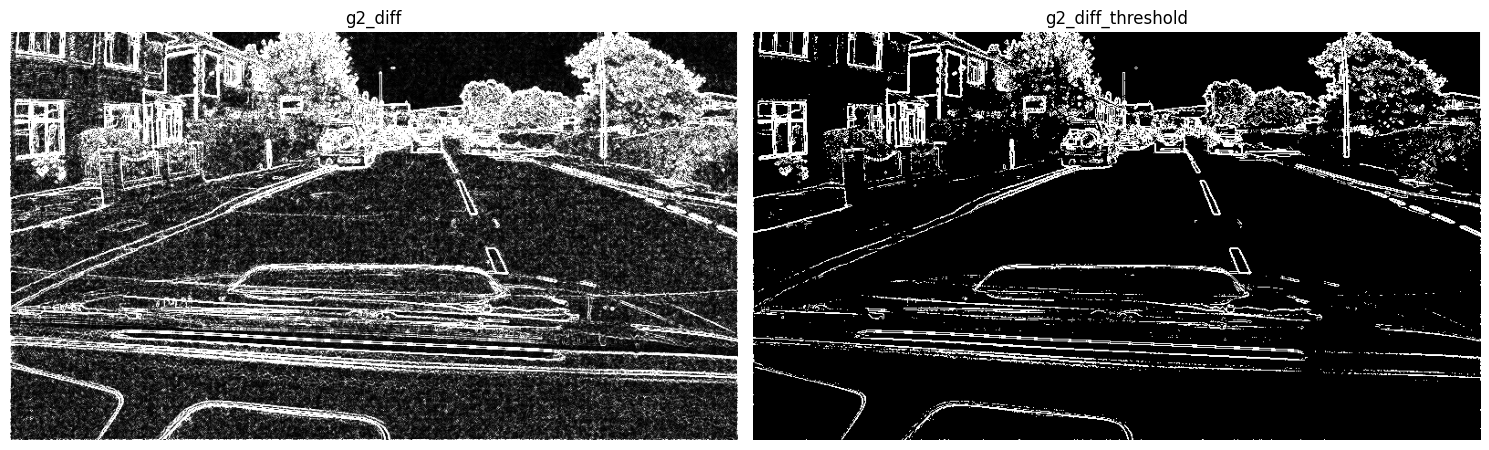

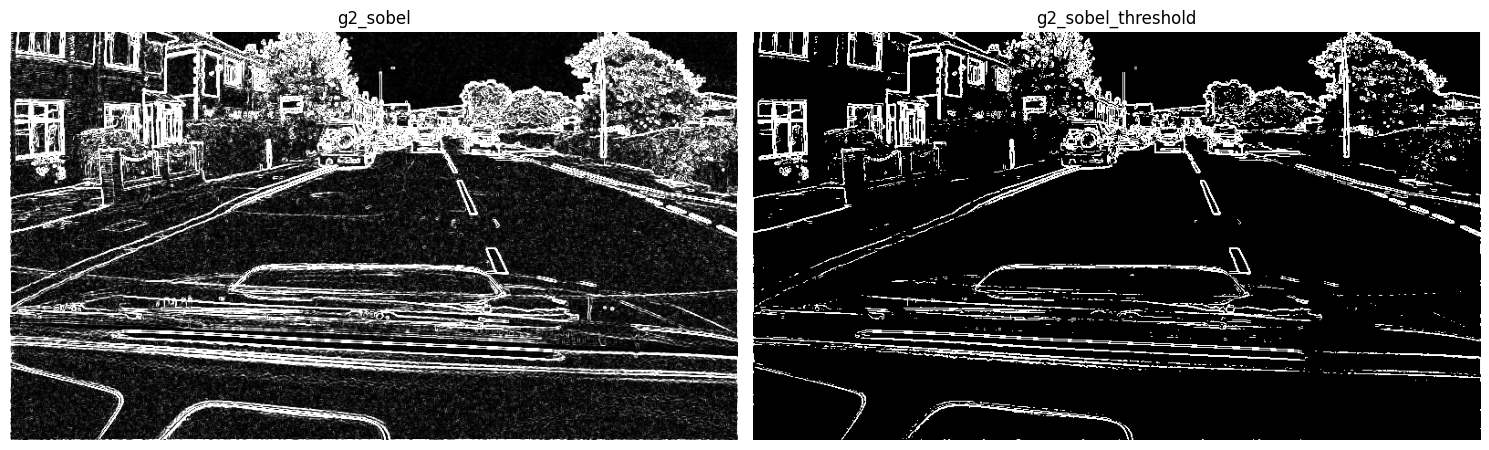

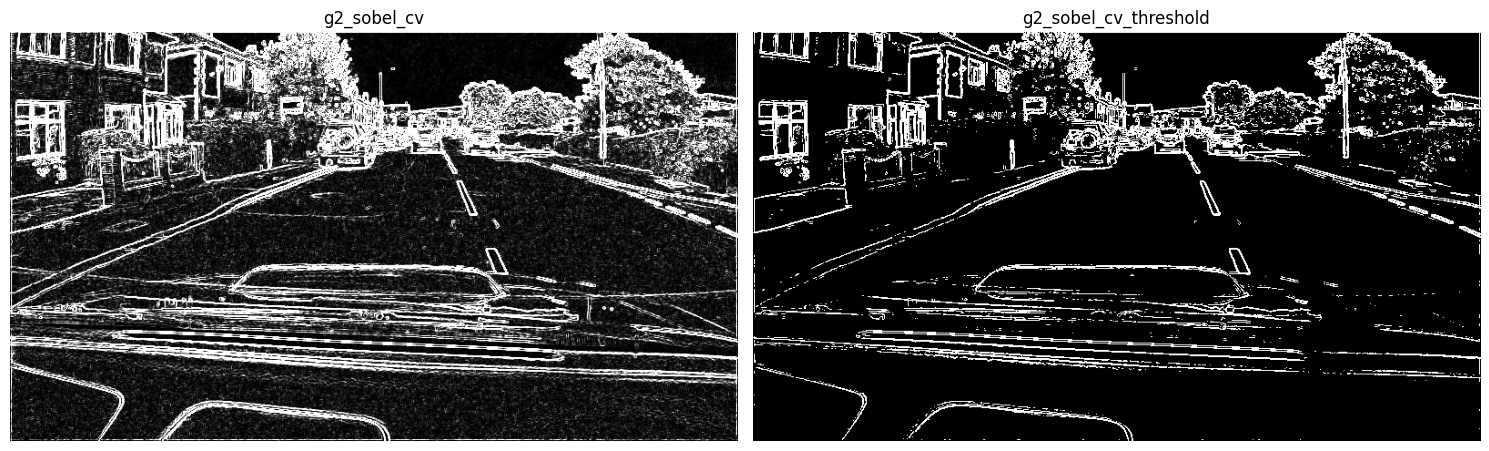

In [10]:
imshow([g2_diff, threshold(g2_diff, g2_diff_threshold)], ['g2_diff', 'g2_diff_threshold'])
imshow([g2_sobel, threshold(g2_sobel, g2_sobel_threshold)], ['g2_sobel', 'g2_sobel_threshold'])
imshow([g2_sobel_cv, threshold(g2_sobel_cv, g2_sobel_cv_threshold)], ['g2_sobel_cv', 'g2_sobel_cv_threshold'])

Try to find the best threshold, that does not select noise, but that misses no meaningful edge. Is that an easy task ?
* Can you see that the *diff* estimation of the gradients is nosier than *Sobel*, as you can see at low threshold values.
* Please comment on the trade-off between a high and a low threshold.

YOUR ANSWER HERE

# Easiness of the task

* This is not a very hard task but neither non-trivial because it is difficult to find the right balance. Once a certain amount of noise is removed it's hard to decide on a final threshold as there is no clear distinction between subtle noise and a 'meaningful edge'.

# The Trade-off Between a High and a Low Threshold

### Low Threshold

* **Pros:** We are less likely to miss important edges, even faint ones. This can gives us a more complete outline of the objects in the scene.

* **Cons:** The resulting image can be very "cluttered." Like in our example without the threshold the image contains a large amount of noise and irrelevant information (like the road texture), which can make it difficult to identify the main object boundaries. 

---

### High Threshold

* **Pros:** We can get a very "clean" image containing only the strongest and most distinct edges. This is excellent for identifying the most prominent features in an image.

* **Cons:** Our risk is losing important information. Weaker edges are completely eliminated, which can lead to broken or fragmented object outlines. For example, a very high threshold might remove the edges defining the windows or parts of the roofline, making the objects harder to recognize.

interactive(children=(IntSlider(value=25, description='value', max=50), Output()), _dom_classes=('widget-inter…

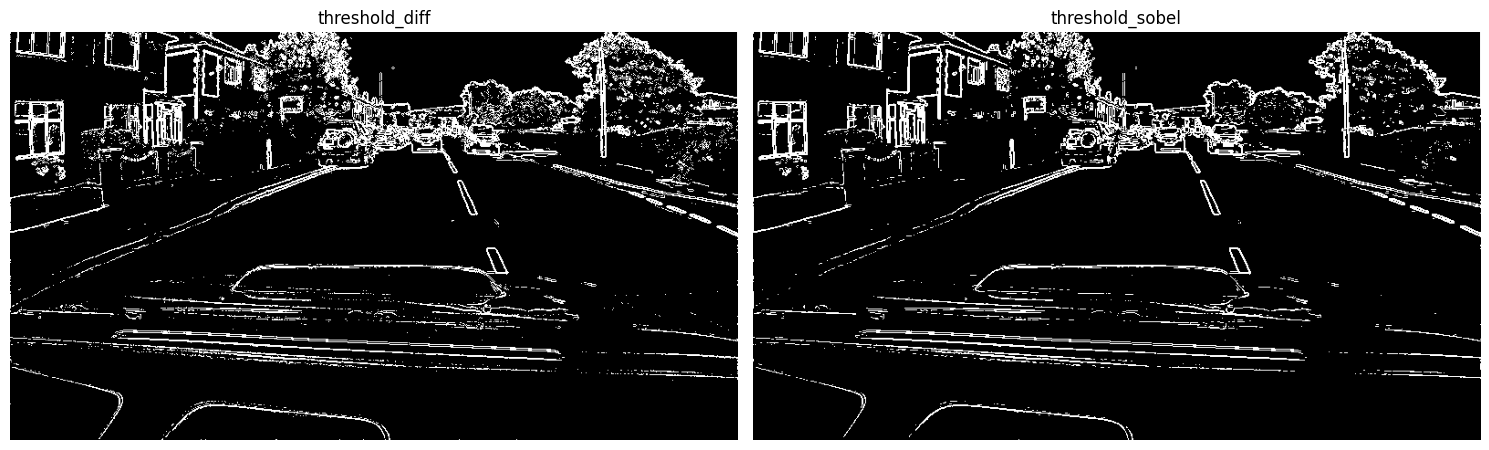

In [11]:
@interact(value = (0,50,1))
def imshow_threshold(value):
  threshold_diff = threshold(g2_diff, value*value)
  threshold_sobel = threshold(g2_sobel, value*value)
  imshow([threshold_diff, threshold_sobel],['threshold_diff', 'threshold_sobel'])

Let us now implement the [Canny edge detector](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html).

- cv2.cartToPolar will help you to convert `gx`, `gy` into polar coordinates `mag`nitude and `ang`le in degrees.
- the output is an image of the same size as the input gradients, with 3 values: 
 - 0 : not an edge
 - 127 : weak edge
 - 255 : strong edge
- non local maximum suppression is carried out by figuring out which quadrant is pointed out by the gradient vector (in degrees) and discard the pixel (edge=0) if it does not have a higher gradient magnitude than its 2 neighbors.
 - [-22.5, 22.5] or [157.5, 202.5] -> horizontal neighbors.
 - [22.5, 67.5] or [202.5, 247.5] -> diagonal neighbors.
 - [67.5, 112.5] or [247.5, 292.5] -> vertical neighbors.
 - [112.5, 157.5] or [292.5, 337.5] -> the other diagonal neighbors.
- queue is a FIFO that is responsible of the selection by breadth-first search of all strong edges (high threshold pixels) and all weak edges that are connected through a path of low threshold pixels to a strong edge. It is initialized with all strong edges. Then we loop over its elements using `while queue` and `queue.popleft` until it is empty. To process a poped element, look at its 8 neighbors and enqueue weak edges if they have not been discovered yet.

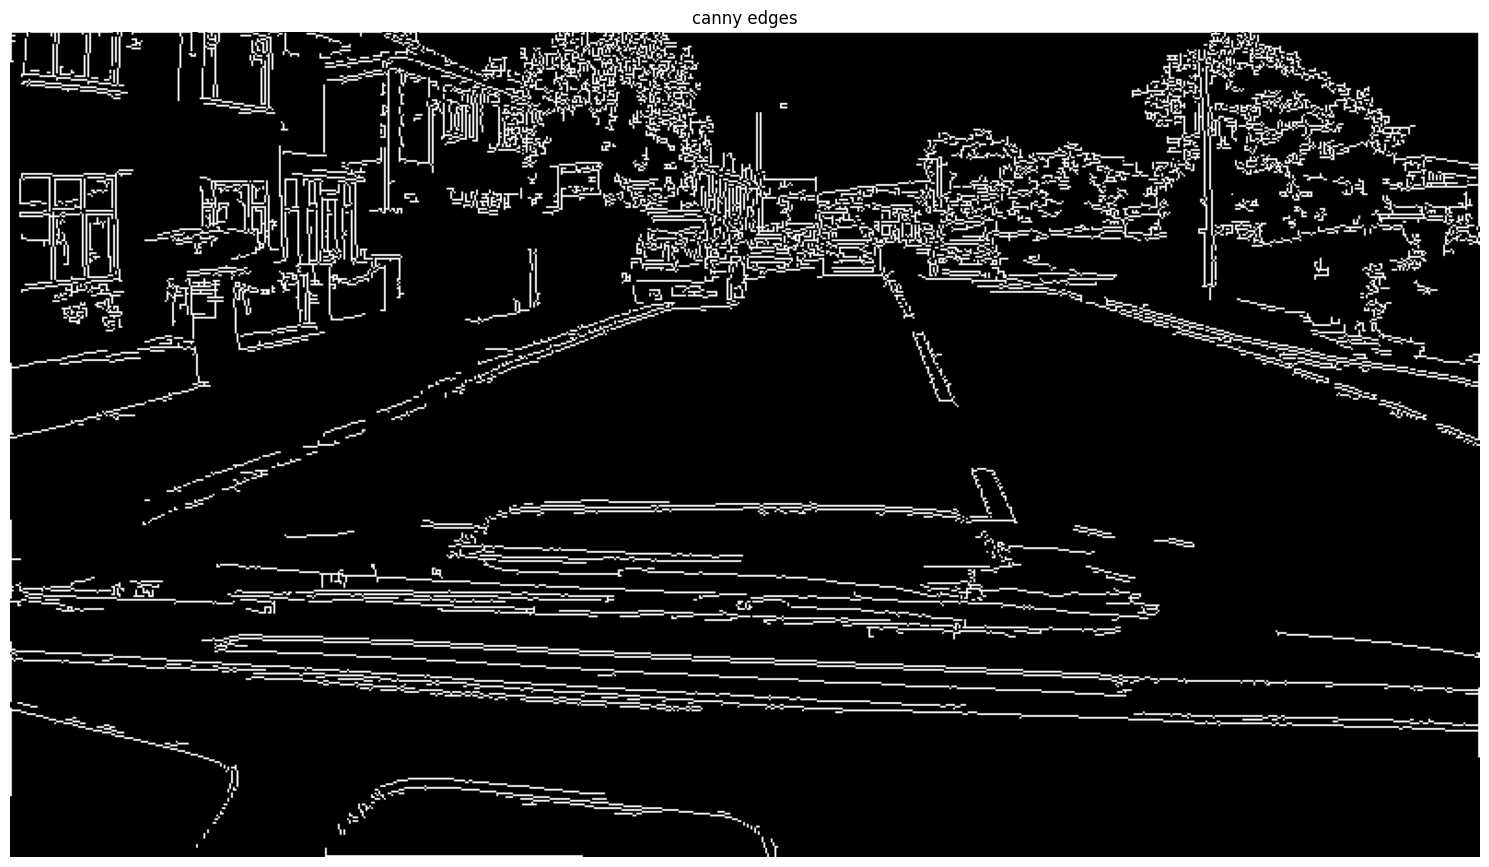

In [12]:
from collections import deque

def canny(gx, gy, low = None, high = None):
  
  mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True) 
  
  if not high: high = 0.5 * mag.max()
  if not low: low = 0.1 * mag.max()

  height, width = mag.shape 
      
  queue = deque()
  edges = np.zeros_like(mag)

  for i_x in range(width): 
      for i_y in range(height): 
              
          grad_ang = ang[i_y, i_x] 
        
        
          # tests to compute the neighbor coordinates in the direction of the gradient grad_ang
          # -> neighb_1_x, neighb_1_y
          # -> neighb_2_x, neighb_2_y
    
          # Determine neighbor coordinates based on gradient angle
          if (grad_ang >= -22.5 and grad_ang <= 22.5) or (grad_ang >= 157.5 and grad_ang <= 202.5):
              # Horizontal neighbors
              neighb_1_x, neighb_1_y = i_x - 1, i_y
              neighb_2_x, neighb_2_y = i_x + 1, i_y
          elif (grad_ang >= 22.5 and grad_ang <= 67.5) or (grad_ang >= 202.5 and grad_ang <= 247.5):
              # Diagonal neighbors (top-left to bottom-right)
              neighb_1_x, neighb_1_y = i_x - 1, i_y - 1
              neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
          elif (grad_ang >= 67.5 and grad_ang <= 112.5) or (grad_ang >= 247.5 and grad_ang <= 292.5):
              # Vertical neighbors
              neighb_1_x, neighb_1_y = i_x, i_y - 1
              neighb_2_x, neighb_2_y = i_x, i_y + 1
          else:  # (grad_ang >= 112.5 and grad_ang <= 157.5) or (grad_ang >= 292.5 and grad_ang <= 337.5)
              # Diagonal neighbors (top-right to bottom-left)
              neighb_1_x, neighb_1_y = i_x + 1, i_y - 1
              neighb_2_x, neighb_2_y = i_x - 1, i_y + 1
              
       
          # Now look at the magnitude of the gradients at the 2 neigbors and 
          # discard i_y,i_x if its magnitude is inferior (by setting mag[i_y, i_x] to 0)
   
          # Check bounds and compare magnitudes for non-maximum suppression
          suppress = False
          if (0 <= neighb_1_x < width and 0 <= neighb_1_y < height):
              if mag[i_y, i_x] <= mag[neighb_1_y, neighb_1_x]:
                  suppress = True
          if (0 <= neighb_2_x < width and 0 <= neighb_2_y < height):
              if mag[i_y, i_x] <= mag[neighb_2_y, neighb_2_x]:
                  suppress = True
          
          if suppress:
              mag[i_y, i_x] = 0

          if mag[i_y, i_x] >= high:
            # append (i_y, i_x) to the queue
            # mark it at a strong edge (assign 255 to this pixel in 'edges')
            queue.append((i_y, i_x))
            edges[i_y, i_x] = 255

  while queue:
    p = queue.popleft()
    py, px = p
    
    # Check all 8 neighbors
    for i in range(-1, 2):
      for j in range(-1, 2):
        if i == 0 and j == 0:
            continue  # Skip the center pixel
        i_y = py + i
        i_x = px + j
        # Check if neighbor is within bounds and is a weak edge that hasn't been processed
        if (0 <= i_x < width and 0 <= i_y < height and 
            mag[i_y, i_x] >= low and edges[i_y, i_x] == 0):
            queue.append((i_y, i_x))
            edges[i_y, i_x] = 255
        
            
  return edges
  
imshow([canny(gx_sobel, gy_sobel, 10, 30)], ['canny edges'])

Finally, you can tune the low and high thresholds of the weak and strong edges to improve the edge detection. What are the best low and high parameters, to get all edges necessary for driving but little unecessary lines ?

Answer:

I argue that the best values are low = 30 and high = 40 as the best values fro driving because from the result image we can see:

* Clean lane markings - continuous and well-defined
* Vehicle boundaries - clearly separated from background
* Road edges - well-defined path boundaries
* Minimal noise - road texture is mostly eliminated

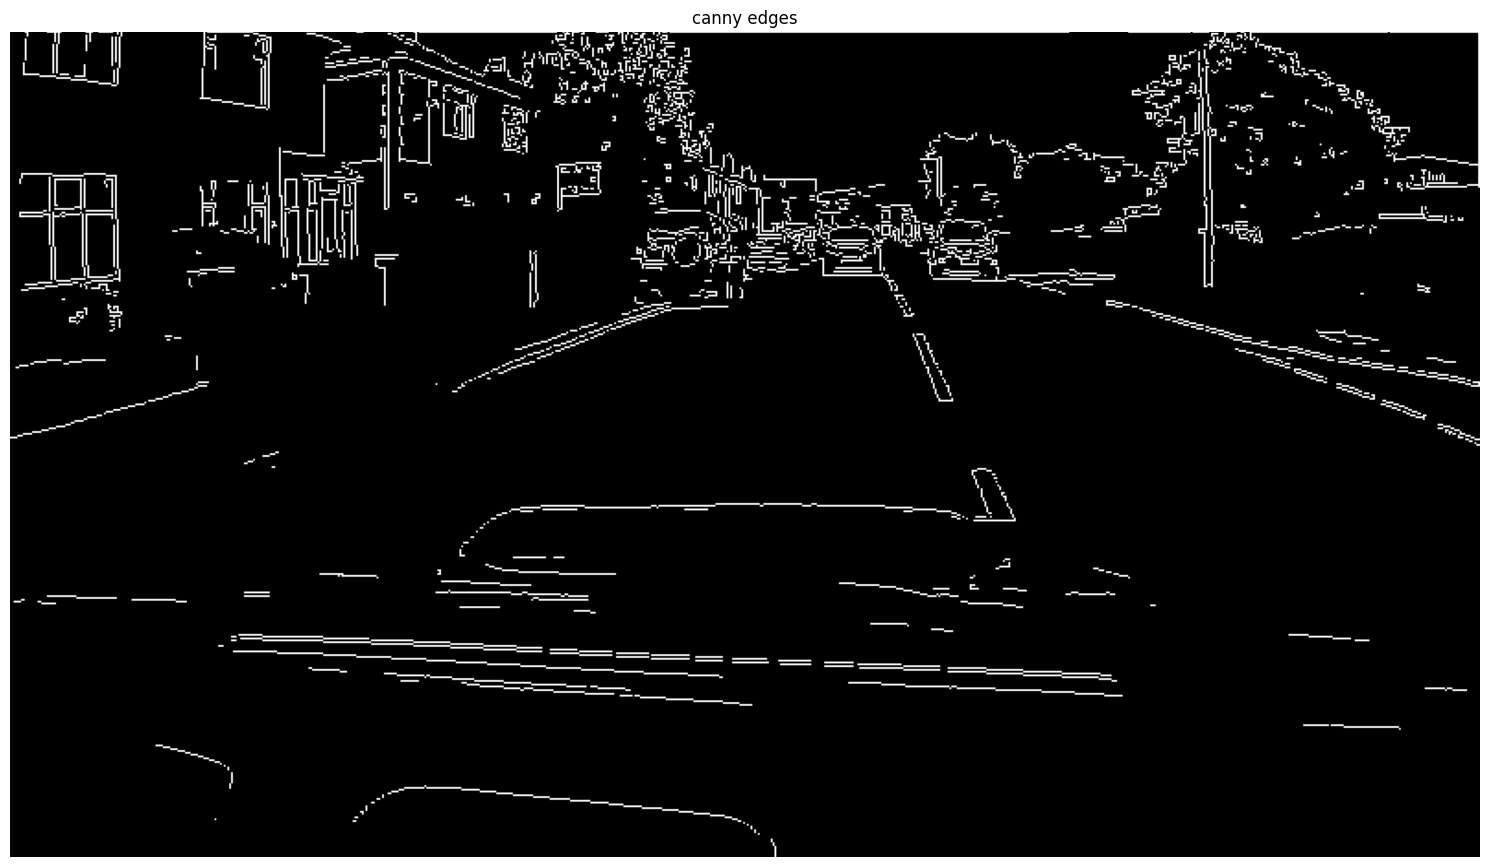

In [13]:
low  = 30
high = 40
# YOUR CODE HERE
imshow([canny(gx_sobel, gy_sobel, 30, 40)], ['canny edges'])

interactive(children=(IntSlider(value=25, description='low', max=50), IntSlider(value=50, description='high'),…

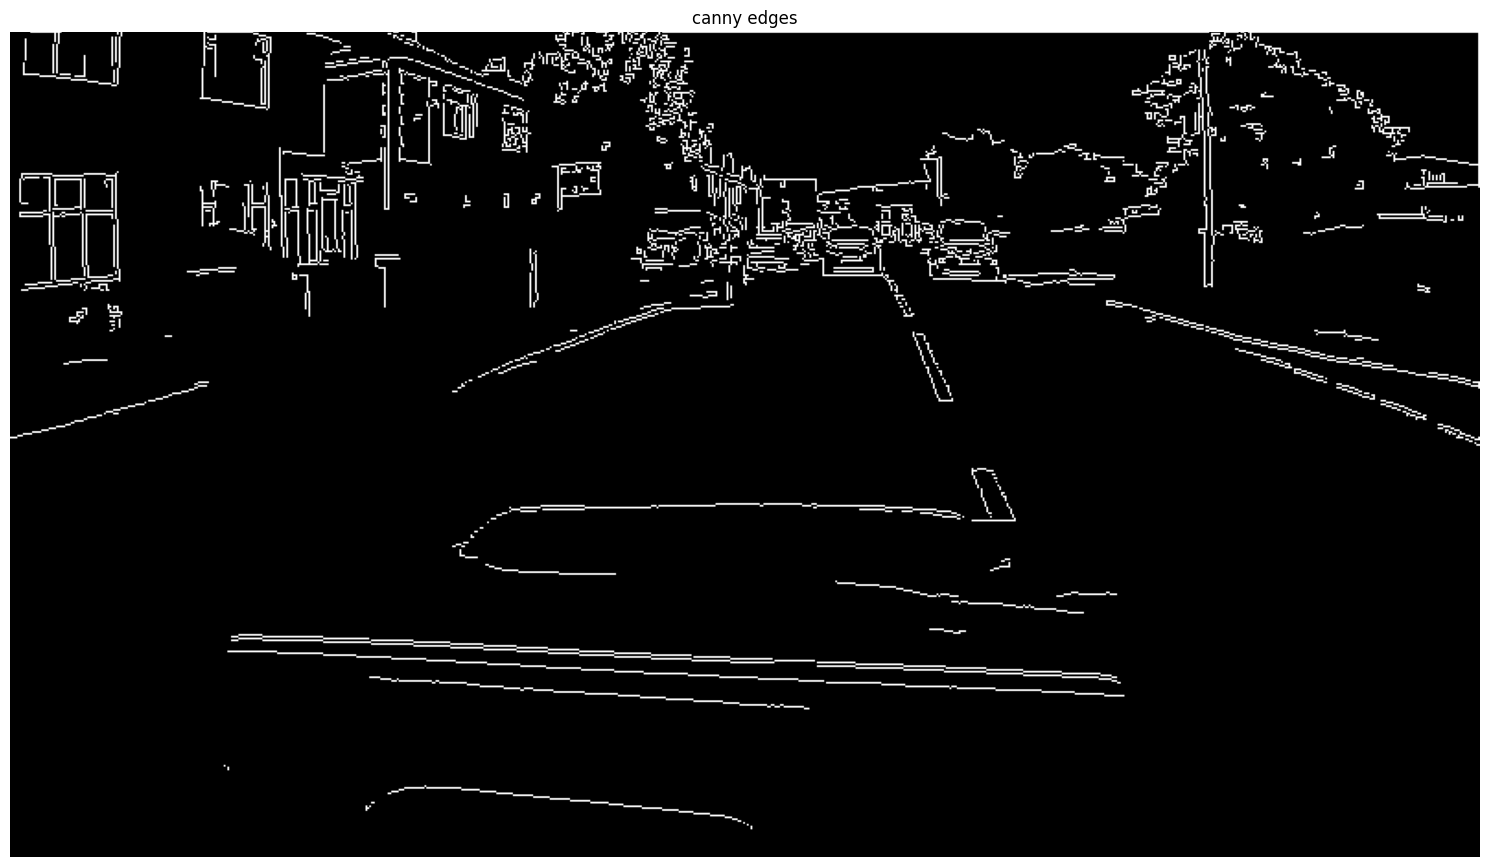

In [14]:
@interact(low = (0,50,1), high = (0,100,1))
def imshow_canny(low, high):
  imshow([canny(gx_sobel, gy_sobel, low, high)], ['canny edges'])

# Extra credits

Implement a Harris Corner detector

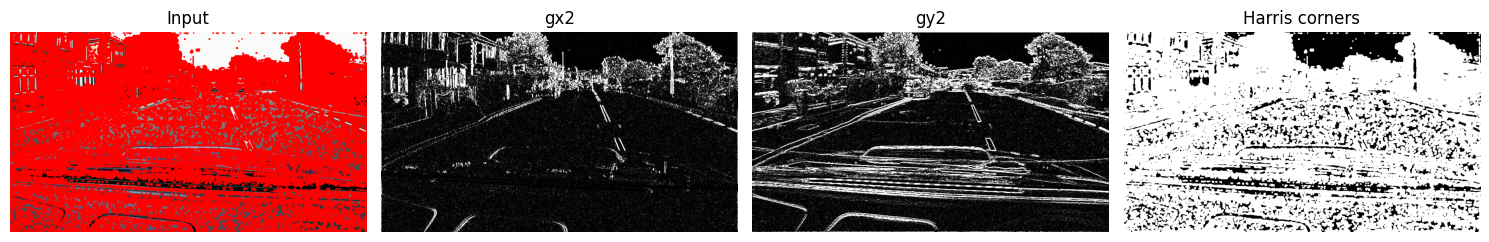

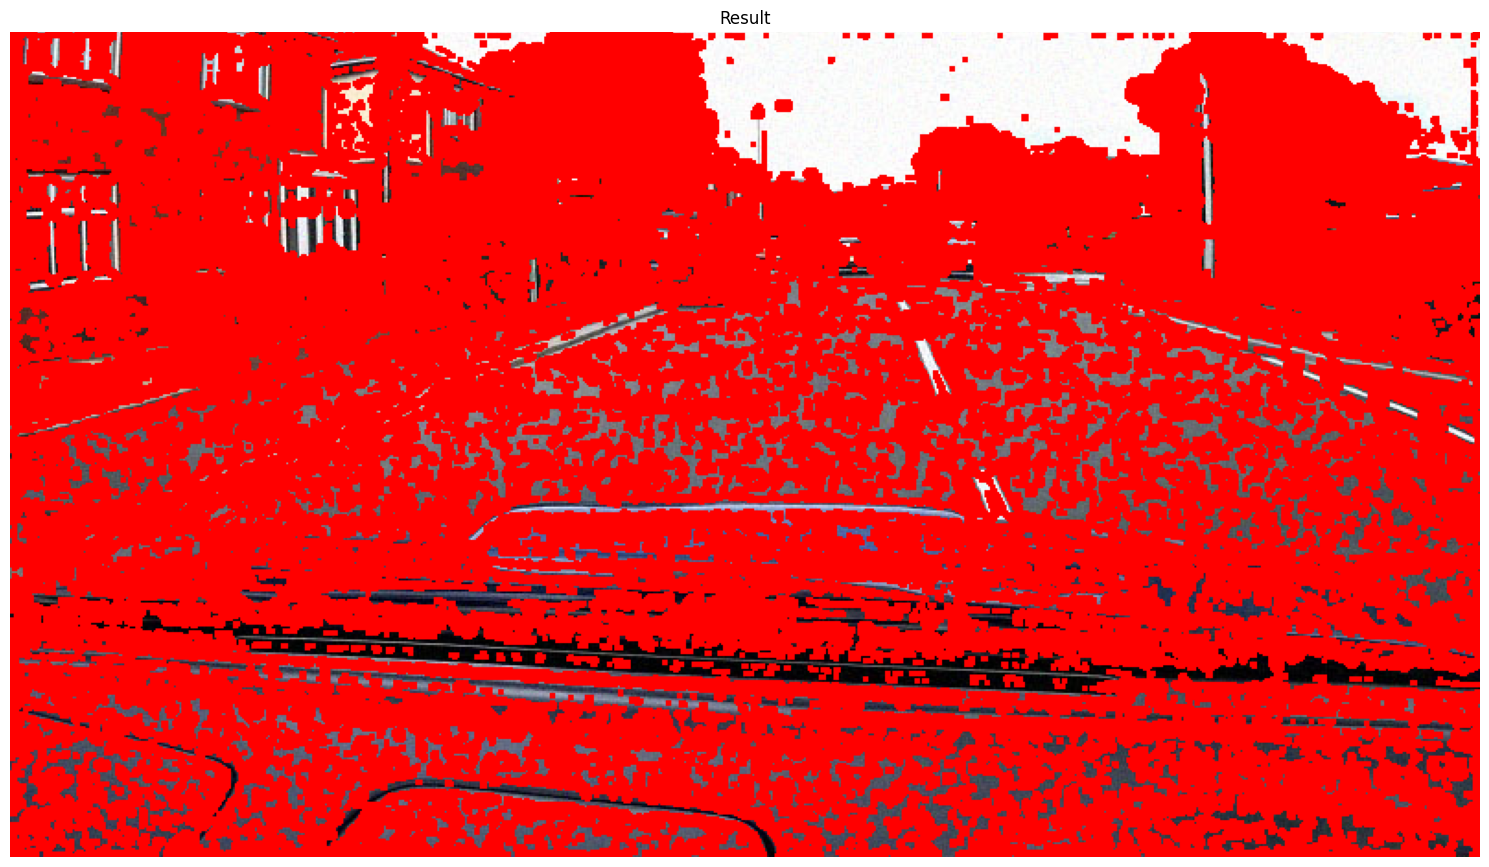

In [15]:
def harris_corner(gx, gy, sigma, threshold):
  gx = gx.astype(float)
  gy = gy.astype(float)

  Ixx = gx * gx  # gx^2
  Iyy = gy * gy  # gy^2
  Ixy = gx * gy  # gx * gy
  
  # Gaussian smoothing to the structure tensor components
  # the key step that makes Harris robust to noise
  kernel_size = int(6 * sigma + 1)  # Rule of thumb: kernel size = 6*sigma
  if kernel_size % 2 == 0:
      kernel_size += 1  # kernel size is odd
  
  Sxx = cv2.GaussianBlur(Ixx, (kernel_size, kernel_size), sigma)
  Syy = cv2.GaussianBlur(Iyy, (kernel_size, kernel_size), sigma)
  Sxy = cv2.GaussianBlur(Ixy, (kernel_size, kernel_size), sigma)
  
  # R = det(M) - k * trace(M)^2
  # where M is the structure tensor matrix [Sxx Sxy; Sxy Syy]
  k = 0.04  # Harris constant (typically 0.04-0.06)
  
  det_M = Sxx * Syy - Sxy * Sxy  # determinant
  trace_M = Sxx + Syy            # trace
  
  R = det_M - k * (trace_M ** 2)
  
  # thresholding to get corner points
  corners = np.zeros_like(R)
  corners[R > threshold] = 255
  
  return corners.astype(np.uint8)
    
image = np.copy(imageBGR[1:-1,1:-1])
harris = harris_corner(gx_sobel, gy_sobel, 1, 50)
harris = cv2.dilate(harris, None)
image[harris>0] = [255, 0, 0]
imshow([image, gx_sobel**2, gy_sobel**2, harris], ['Input', 'gx2', 'gy2','Harris corners'])
imshow([image], ['Result'])